# Monte Carlo Simulation for Profolio

In our previous analysis, we focused on enhancing the success rates of a stock investment portfolio through fundamental analysis and optimization techniques. Now, we're taking our analysis a step further by employing a Monte Carlo simulation on the same portfolio. This simulation enables us to assess the portfolio's risk and return characteristics by generating numerous random scenarios based on statistical distributions.

**Monte Carlo simulations are a valuable tool for modeling the uncertainty and variability inherent in investment outcomes.**

In [116]:
!pip install PyPortfolioOpt

In [117]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm

import yfinance as yf

In [118]:
def mean_variance_optimization(stocks_list):
    from pypfopt.expected_returns import mean_historical_return
    from pypfopt.risk_models import CovarianceShrinkage
    from pypfopt.efficient_frontier import EfficientFrontier
    from pypfopt import plotting

    start_date = "2019-01-01"
    end_date = "2022-12-31"

    portfolio = yf.download(stocks_list,start=start_date, end=end_date)['Close'].dropna()

    mu = mean_historical_return(portfolio)
    S = CovarianceShrinkage(portfolio).ledoit_wolf()


    ef = EfficientFrontier(mu, S)
    weights = ef.max_sharpe()

    cleaned_weights = ef.clean_weights()

    ef.portfolio_performance(verbose=True)

    portfolio_weights = []
    for stock in weights:
      portfolio_weights.append(weights[stock])
    portfolio_weights = np.array(portfolio_weights)

    return portfolio_weights

def calculate_daily_return(df):
  df_daily_return = df.copy()
  for i in df.columns[:]:
    for j in range(0, len(df)):
      df_daily_return[i][j] = ((df[i][j]- df[i][j-1])/df[i][j-1]) * 100
    df_daily_return[i][0] = 0
  return df_daily_return

def calculate_portfolio_returns(stock_returns, weights):
    """
    Calculate the portfolio daily returns based on allocation weights and stock returns.

    Parameters:
    - stock_returns (pandas.DataFrame): A DataFrame containing daily returns of individual stocks.
    - weights (list or numpy.ndarray): A list or array containing allocation weights for each stock.

    Returns:
    - portfolio_returns (pandas.Series): A Series containing daily portfolio returns.
    """
    portfolio_returns = stock_returns.dot(weights)
    return portfolio_returns

## Visualize the cumulative returns for the optimized portfolio in 2023

[*********************100%%**********************]  14 of 14 completed
[*********************100%%**********************]  14 of 14 completed


Expected annual return: 45.9%
Annual volatility: 39.1%
Sharpe Ratio: 1.12


<Axes: title={'center': 'Portfolio of Mean Variance Optimization'}, xlabel='Date', ylabel='Cumulative Return'>

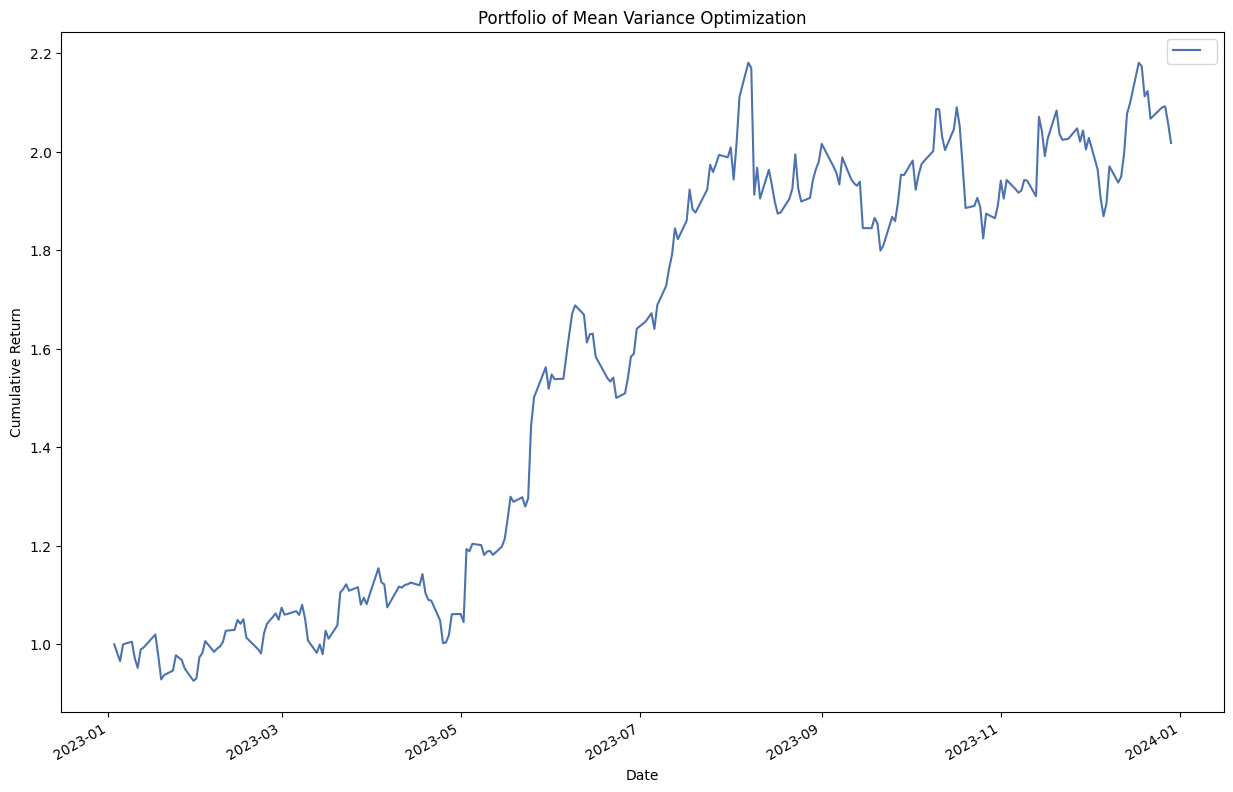

In [119]:
start_date = "2023-01-01"
end_date = "2023-12-31"

stocks_list = ['ON','ANET','SMCI','GOOG','NFLX','ADBE','LAD','MLI','DVN','TPL','XOM','CVX','DECK','MTDR']

portfolio = yf.download(stocks_list,start=start_date, end=end_date)['Close'].dropna()
portfolio_weights = mean_variance_optimization(stocks_list)
portfolio_daily_return = calculate_daily_return(portfolio)

# Calculate portfolio daily returns based on allocation weights and stock returns
portfolio_daily_returns = calculate_portfolio_returns(portfolio_daily_return, portfolio_weights)

# Calculate cumulative returns for the portfolio in  2023
portfolio_cumulative_returns = (1 + (portfolio_daily_returns / 100)).cumprod()

portfolio_cumulative_returns.plot(legend = True, figsize=(15,10),title = "Portfolio of Mean Variance Optimization", ylabel = "Cumulative Return")

## Calculating and plotting the moving averages for different numbers of days

<Axes: xlabel='Date'>

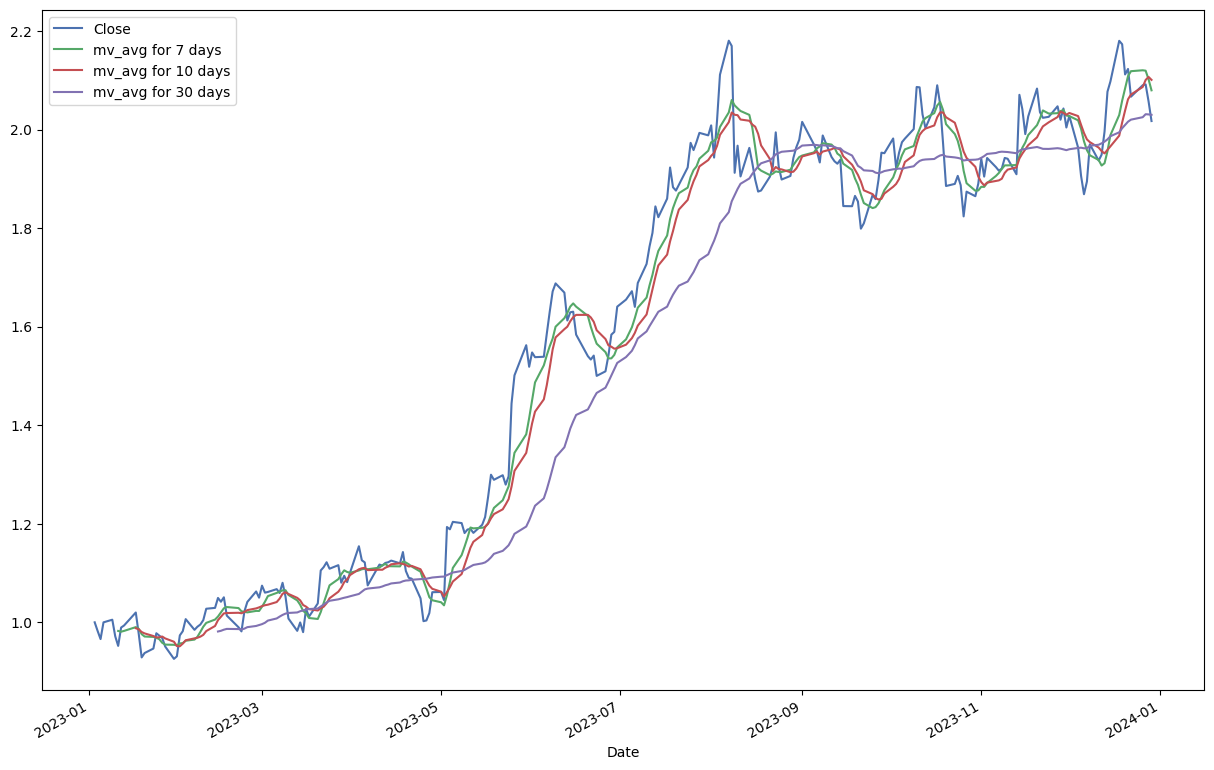

In [121]:
data = pd.DataFrame({'Close' : portfolio_cumulative_returns})

days = [7, 10 , 30] # Multiple number of days
for day in days:
    col_name = "mv_avg for " + str(day) + " days"
    data[col_name] = portfolio_cumulative_returns.rolling(day).mean()

data[['Close', 'mv_avg for 7 days', 'mv_avg for 10 days', 'mv_avg for 30 days']].plot(subplots = False, figsize=(15,10))

## Calculating and plotting the daily returns of the portfolio based on the cumulative returns

<Axes: xlabel='Date', ylabel='Percentage Change'>

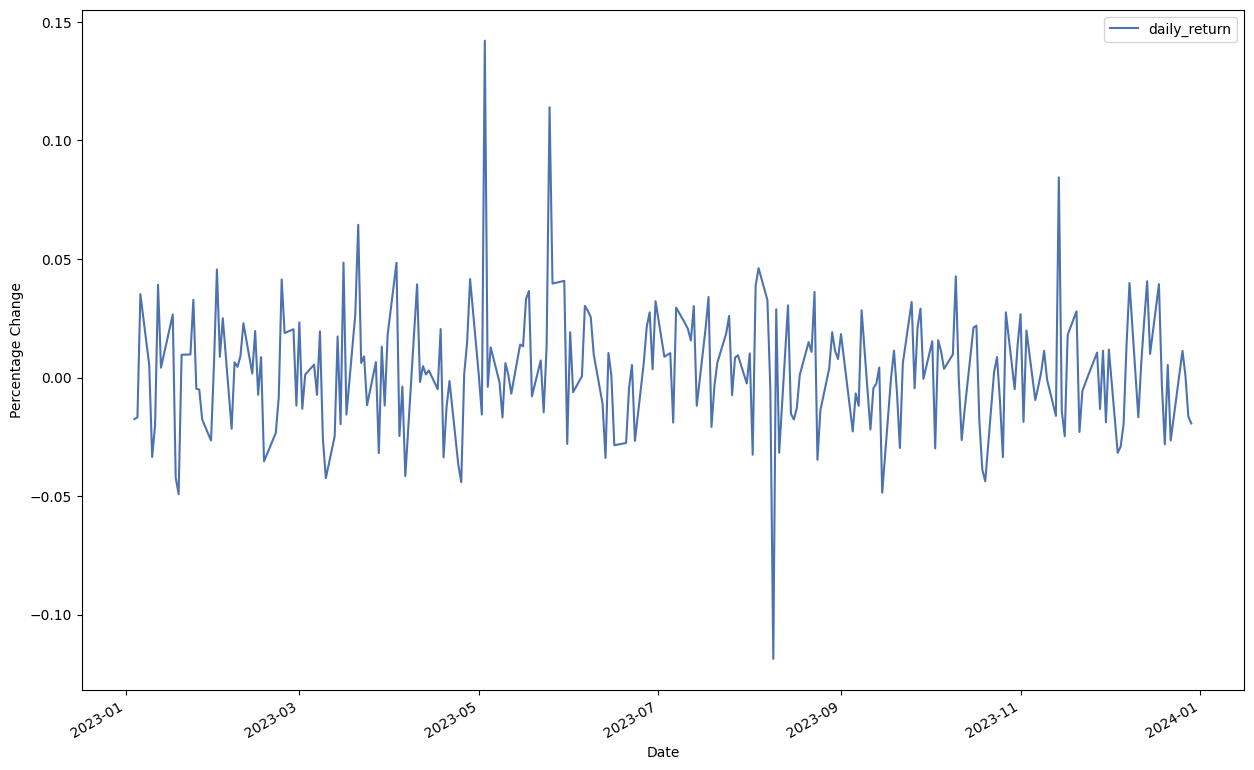

In [122]:
daily_return = data['Close'].pct_change() # Calculate the daily returns

data['daily_return'] = daily_return # Create new column and assign daily return values to it

plt.ylabel('Percentage Change') # Assign a name to the y-axis of plot

data['daily_return'].plot(legend = True, figsize=(15,10)) # plot the daily return values

To visualize the results, we can create a histogram of the simulated portfolio returns. This histogram illustrates the frequency or probability distribution of returns, allowing us to grasp the potential outcomes and evaluate the portfolio's risk profile.

Text(13.694444444444445, 0.5, 'Probability Density Value')

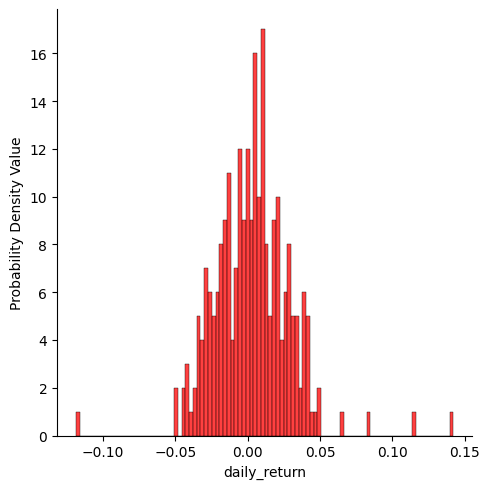

In [123]:
sns.displot(data['daily_return'].dropna(), bins = 100, color = 'red') # plots a distribution graph of KDE and histogram
plt.ylabel('Probability Density Value') # Assign a name to the y-axis of plot

We set the number of simulations we want to conduct. The more simulations we perform, the more accurate our analysis becomes. For each simulation, we generate random returns for each stock based on their expected returns and standard deviations. This random generation allows us to simulate a wide range of potential outcomes for the portfolio.

The Minimum Predicted Price: 1.4325258079136247
The Maximum Predicted Price: 4.2533918249369735


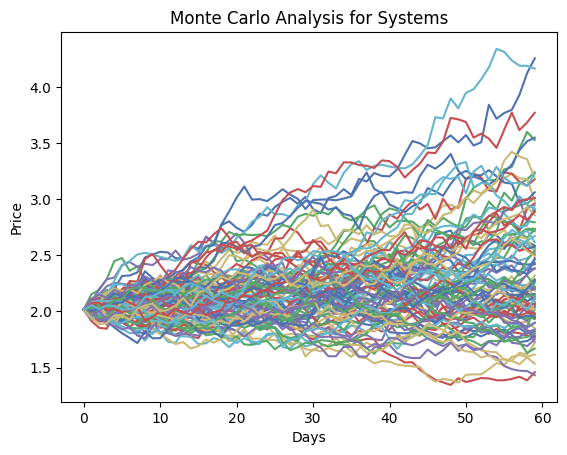

In [130]:
# Calculating log returns from daily returns
log_returns = np.log(1 + daily_return)

avg = log_returns.mean() # Calculating average of log returns
var = log_returns.var() # Calculating variance

drift = avg - (var / 2.0) # Calculating drift

drift = np.array(drift) # Convert to array

pred_price_overDays = 60 # Number of days
pred_count = 90 # Range of prediction

std = log_returns.std() # Calculating STD
std = np.array(std) # Convert to array

x = np.random.rand(pred_price_overDays, pred_count) # get random multidimensional array

Rv = std * norm.ppf(x) # Calculating Rv

e_value = np.exp(drift + Rv) # Calculating the E value

current_price = data['Close'].iloc[-1] # Selecting last price of the year

new_prices = np.zeros_like(e_value) # create array to store the results

new_prices[0] = current_price

for i in range(1, pred_price_overDays): # Loop over all the days to find their prices
    new_prices[i] = new_prices[i - 1] * e_value[i] # Calculating the future price with formula

print("The Minimum Predicted Price:", new_prices[pred_price_overDays-1].min()) # Get minimum price
print("The Maximum Predicted Price:", new_prices[pred_price_overDays-1].max()) # Get maximum price

plt.xlabel('Days') # Assign name to x-axis
plt.ylabel('Price') # Assign name to y-axis
plt.title('Monte Carlo Analysis for Systems') # Assign name to the plot
plt.plot(new_prices)# plot the figure

The minimum predicted price, **1.43** is the lowest possible cumulative return based on the Monte Carlo simulation, while the maximum predicted price, **4.25** is the highest possible cumulative return. They represent the lower and upper bounds, respectively, for the predicted cumulative return, providing insight into the potential range of outcomes and uncertainty.

[*********************100%%**********************]  14 of 14 completed


<Axes: title={'center': 'Portfolio of Mean Variance Optimization'}, xlabel='Date', ylabel='Cumulative Return'>

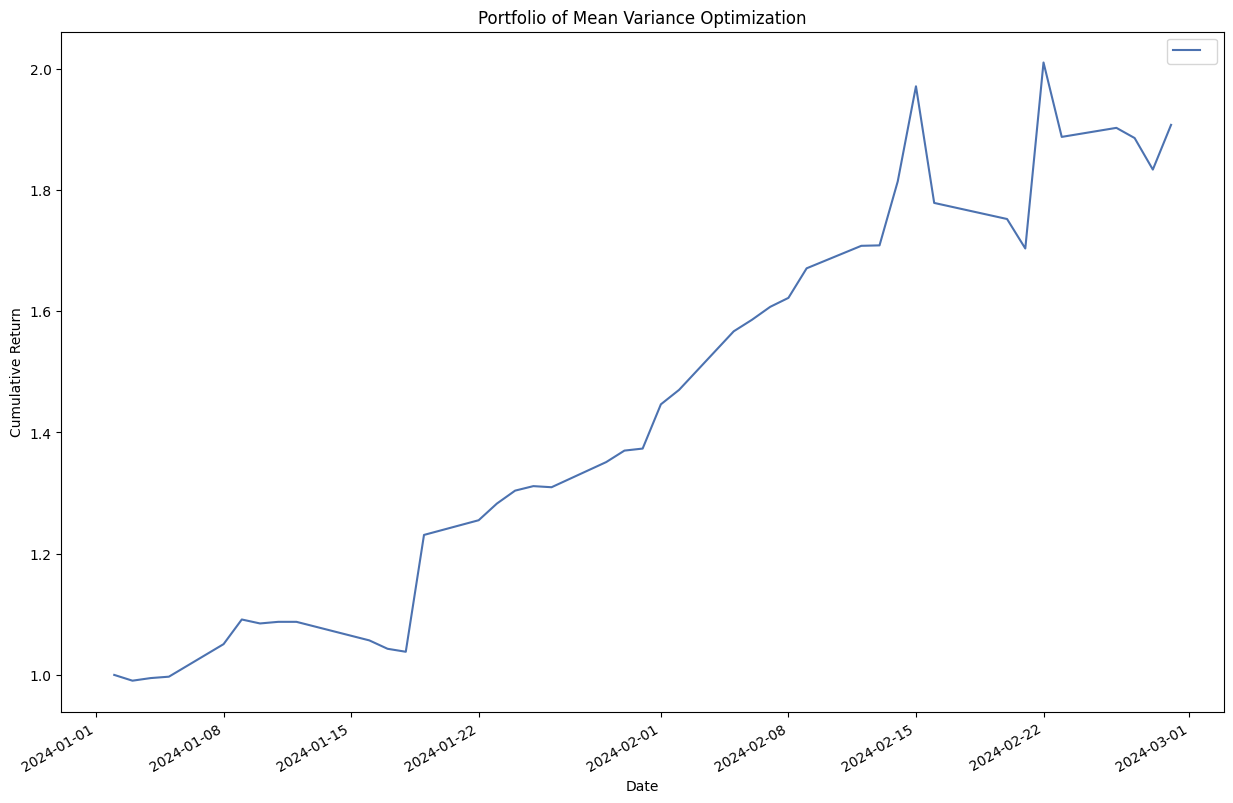

In [131]:
start_date = "2024-01-01"
end_date = "2024-03-01"

stocks_list = ['ON','ANET','SMCI','GOOG','NFLX','ADBE','LAD','MLI','DVN','TPL','XOM','CVX','DECK','MTDR']

portfolio = yf.download(stocks_list,start=start_date, end=end_date)['Close'].dropna()

portfolio_daily_return = calculate_daily_return(portfolio)

# Calculate portfolio daily returns based on allocation weights and stock returns
portfolio_daily_returns = calculate_portfolio_returns(portfolio_daily_return, portfolio_weights)

# Calculate cumulative returns for the portfolio in  2023
portfolio_cumulative_returns = (1 + (portfolio_daily_returns / 100)).cumprod()

portfolio_cumulative_returns.plot(legend = True, figsize=(15,10),title = "Portfolio of Mean Variance Optimization", ylabel = "Cumulative Return")

In [135]:
print("On March 1, 2024, the cumulative return is ", portfolio_cumulative_returns[-1].round(2))

On March 1, 2024, the cumulative return is  1.91


In comparison, the actual cumulative return from the backtest is **1.91**. This suggests that **the realized return falls between the minimum and maximum predicted values, closer to the lower end of the range.**